# Task 1: Big Cats
### Alina, Lisa, Ömer and Nikolai

## Import Data

In [16]:
import os

import cv2 as cv
import imgaug.augmenters as iaa
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.facecolor"] = "w"
plt.rc('axes', axisbelow=True)
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [17]:
RANDOM_STATE=50

In [18]:
data_path = os.path.join("..", "Data-PR-As2", "BigCats")

In [19]:
class_paths = os.listdir(data_path)
imgs = []
labels = []
for class_ in class_paths:
    path = os.path.join(data_path, class_)
    imgs_of_class = os.listdir(path)
    imgs += [os.path.join(path, x) for x in imgs_of_class]
    labels += [class_] * len(imgs_of_class)

## Data Analysis

In [20]:
print("# observations:", len(labels))

# observations: 170


In [21]:
classes = list(np.unique(labels))
n_classes = len(classes)
print("There are", n_classes, "classes:", classes)

There are 5 classes: ['Cheetah', 'Jaguar', 'Leopard', 'Lion', 'Tiger']


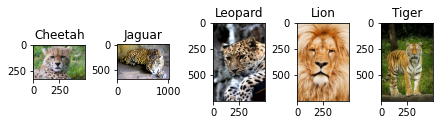

In [22]:
# Visualise one data sample per class
fig, axs = plt.subplots(1, n_classes, constrained_layout=True)
axs = axs.flatten()

for i, class_ in enumerate(classes):
    ob_idx = labels.index(class_)
    with Image.open(imgs[ob_idx]) as img:
        axs[i].imshow(img)
        axs[i].title.set_text(class_)
plt.show()

In [23]:
def plot_class_freq(y):
    ax = y.apply(pd.value_counts).plot(kind='bar', legend=False)
    if matplotlib.__version__[:3] != "3.3":
        ax.bar_label(ax.containers[0])
    else:
        print("Warning using old version of matplotlib!")
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.show()

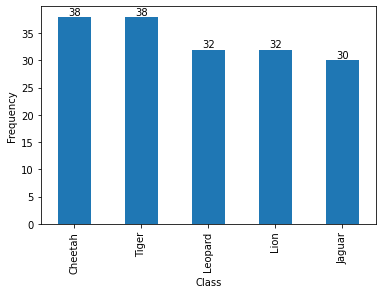

In [24]:
# Check for data imbalance
plot_class_freq(pd.DataFrame(labels))

## Data Augmentation

In [25]:
def aug_data(data, labels, display_idx={}):
    all_imgs = []
    all_labels = []
    aug_seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.PiecewiseAffine(scale=(0.01, 0.05)),
        iaa.PerspectiveTransform(scale=(0.05, 0.15))
    ])

    for i, x in enumerate(data):
        img = cv.imread(x)
        img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
        aug_img = aug_seq(images=[img])

        all_imgs.append(img)
        all_imgs.append(aug_img[0])
        all_labels.append(labels[i])
        all_labels.append(labels[i])

        if i in display_idx:
            fig, axs = plt.subplots(1, 2, constrained_layout=True)
            axs = axs.flatten()
            axs[0].imshow(img)
            axs[0].title.set_text('Original')
            axs[1].imshow(aug_img[0])
            axs[1].title.set_text('Augmented')
            plt.show()

    return all_imgs, all_labels

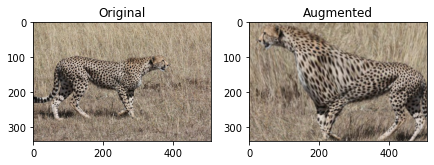

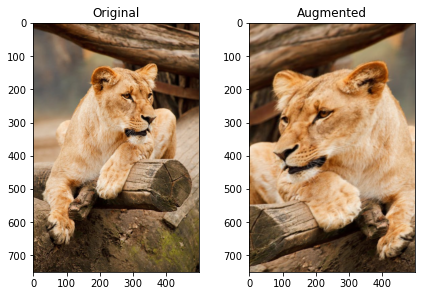

In [26]:
all_imgs, all_labels = aug_data(imgs, labels, {2, 101})

## Classification

In [27]:
img_train, img_test, label_train, label_test = train_test_split(all_imgs, all_labels, test_size=0.2, random_state=RANDOM_STATE)

### General Functions

In [28]:
# Evaluation
def run_model(model, train_data, train_labels, test_data, test_labels):
    model.fit(train_data, train_labels)
    yhat = model.predict(test_data)

    accuracy = accuracy_score(test_labels, yhat)
    print("Accuracy: " + str(accuracy * 100) + "%")

    f_1 = f1_score(test_labels, yhat, average=None)
    print("F_1: " + str(f_1))

    conf_mat = confusion_matrix(test_labels, yhat)
    conf_mat_df = pd.DataFrame(conf_mat, columns=classes, index=classes)
    sns.set(rc={'figure.facecolor':'white'})
    fig = sns.heatmap(conf_mat_df, annot=True, cmap=sns.cm.rocket_r)
    plt.show()

    # roc_auc = roc_auc_score(test_labels, yhat, average=None, multi_class='ovo')

### SIFT

#### Feature Extraction

In [29]:
def process_img(img):
    # img = cv.GaussianBlur(img,(13,13),0) # did not help
    # img = cv.addWeighted(img, 4, cv.blur(img, (30, 30)), -4, 128)
    # _, img = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    return img

def extract_with_sift(data, num_des=247, display_idxs={}):
    sift = cv.SIFT_create()
    features = np.array([])
    
    for i, img in enumerate(data):
        bw_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        bw_img = process_img(bw_img)

        kp, des = sift.detectAndCompute(bw_img, None)
        features = np.vstack((des, features)) if features.size else des
        
        if i in display_idxs:
            img_sift = cv.drawKeypoints(bw_img, kp, img, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            plt.imshow(img_sift)
            plt.show()
    
    return features

#### Bag of Visual Words

Create dictionary by clustering descriptors

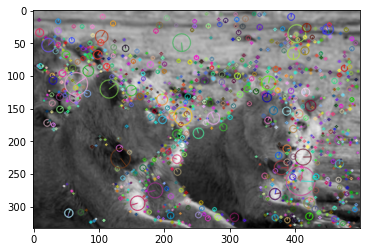

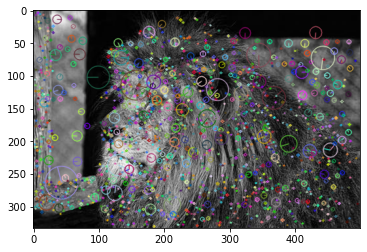

KMeans(n_clusters=100, random_state=50)

In [30]:
all_train_features = extract_with_sift(img_train, display_idxs={0, 5})

# This takes a while
N_CLUSTERS=100
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE)
kmeans.fit(all_train_features)

Helper functions

In [31]:
# Returns a normalized histogram of the dictionary word frequency
# using the SIFT descriptors of an image
def build_histogram(kmeans_dict, img_des):
    pred = kmeans_dict.predict(img_des)
    hist, _ = np.histogram(pred, bins=N_CLUSTERS)
    # hist_norm = [float(i)/sum(hist) for i in hist] # comment if running with tf_idf
    return hist

# Reflects importance of BOVW features in the image histograms
# See https://en.wikipedia.org/wiki/Tf%E2%80%93idf for more information
def tf_idf_histogram(train_hists, test_hists):
    hists = np.concatenate((np.array(train_hists), np.array(test_hists)), axis=0)
    tf_idf_hists = np.zeros(hists.shape)
    N = hists.shape[0] # total number of images
    n_i = np.sum(hists > 0, axis=0) # number of images where the word w appears (per word)
    
    for hist_id in range(N):
        n_words_i = np.sum(hists[hist_id]) # number of words in the image

        for word_id in range(len(hists[hist_id])):
            n_wi = hists[hist_id, word_id] # count of word w in image i
            tf_idf_hists[hist_id, word_id] = n_wi / n_words_i * np.log(N/n_i[word_id])

        # Normalize hist_id histogram
        tf_idf_hists[hist_id] = [float(i)/sum(tf_idf_hists[hist_id]) for i in tf_idf_hists[hist_id]]
        
    return tf_idf_hists[:len(train_hists)], tf_idf_hists[-len(test_hists):]

Extract BoVW features

In [32]:
kmeans_train_features = []
for img_id in range(len(img_train)):
    if img_train[img_id] is not None:
        d = [img_train[img_id]]
        kmeans_train_features.append(build_histogram(kmeans, extract_with_sift(d)))
    else:
        label_train.pop(img_id)

kmeans_test_features = []       
for img_id in range(len(img_test)):
    if img_test[img_id] is not None:
        d = [img_test[img_id]]
        kmeans_test_features.append(build_histogram(kmeans, extract_with_sift(d)))
    else:
        label_test.pop(img_id)

kmeans_train_features, kmeans_test_features = tf_idf_histogram(kmeans_train_features, kmeans_test_features)

Evaluate with:
    - Random forest classifier
    - Support vector machine

Evaluation with Random Forest Classifier:
Accuracy: 69.11764705882352%
F_1: [0.72727273 0.57142857 0.72       0.61538462 0.77419355]


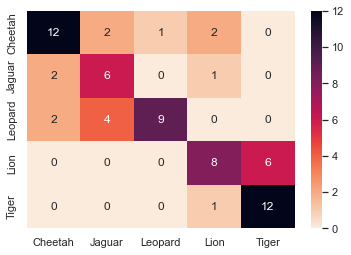


Evaluation with SVM:
Accuracy: 69.11764705882352%
F_1: [0.66666667 0.53846154 0.52173913 0.78571429 0.89655172]


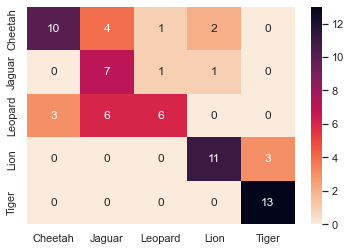

In [33]:
print("Evaluation with Random Forest Classifier:")
run_model(RandomForestClassifier(), kmeans_train_features, label_train, kmeans_test_features, label_test)

print("\nEvaluation with SVM:")
run_model(SVC(), kmeans_train_features, label_train, kmeans_test_features, label_test)

### FFT

#### Feature Extraction

In [34]:
def fft_spectrum_1D(bw_img):
    f = np.fft.fft2(bw_img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 10*np.log(np.abs(fshift))

    rows, cols = magnitude_spectrum.shape
    magnitude_spectrum_1D = 20*magnitude_spectrum.reshape(rows*cols)

    return magnitude_spectrum.reshape(rows*cols)

def extract_with_fourier(data, display_idxs={}):
    features = []

    for i, img in enumerate(data):
        bw_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        bw_img = cv.resize(bw_img, (200, 200))
        features.append(fft_spectrum_1D(bw_img))

    return np.array(features)

In [35]:
train_features = extract_with_fourier(img_train, display_idxs={0, 5})
test_features = extract_with_fourier(img_test)

#### Cross Validation

In [36]:
scores = cross_val_score(KNeighborsClassifier(), train_features, label_train, cv=10)
print("KNN Classifier: %0.2f%% accuracy with a standard deviation of %0.2f" % (scores.mean()*100, scores.std()))

scores = cross_val_score(RandomForestClassifier(), train_features, label_train, cv=10)
print("Random Forest Classifier: %0.2f%% accuracy with a standard deviation of %0.2f" % (scores.mean()*100, scores.std()))

scores = cross_val_score(SVC(), train_features, label_train, cv=10)
print("SVM: %0.2f%% accuracy with a standard deviation of %0.2f" % (scores.mean()*100, scores.std()))

KNN Classifier: 38.60% accuracy with a standard deviation of 0.10
Random Forest Classifier: 40.42% accuracy with a standard deviation of 0.07
SVM: 40.03% accuracy with a standard deviation of 0.05


#### Evaluation


Evaluation with KNN:
Accuracy: 30.88235294117647%
F_1: [0.20689655 0.375      0.0952381  0.57142857 0.22857143]


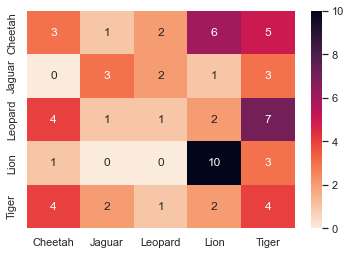

Evaluation with Random Forest Classifier:
Accuracy: 38.23529411764706%
F_1: [0.3030303  0.5        0.21052632 0.54545455 0.32258065]


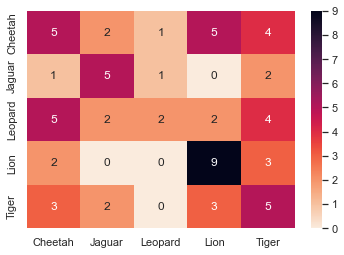


Evaluation with SVM:
Accuracy: 36.76470588235294%
F_1: [0.3030303  0.42105263 0.         0.60606061 0.33333333]


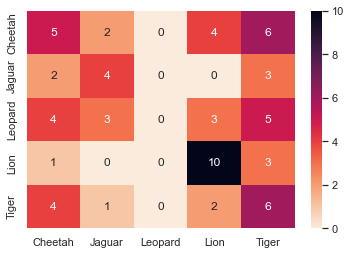

In [37]:
print("\nEvaluation with KNN:")
score = run_model(KNeighborsClassifier(), train_features, label_train, test_features, label_test)

print("Evaluation with Random Forest Classifier:")
score = run_model(RandomForestClassifier(), train_features, label_train, test_features, label_test)

print("\nEvaluation with SVM:")
score = run_model(SVC(), train_features, label_train, test_features, label_test)